# Challenges

## Choice of xc-functional

```{note}
To add:
- HOMO-LUMO gap (BxLYP)
- Point to exercise
```

## Self-interaction

```{note}
To add:
- 1/R
- Refer to DFT SIE example
- Mention inpact on core transitions
- Mention [Devli's triangle](https://aip.scitation.org/doi/10.1063/5.0035446)
```

## Transitions to Rydberg states

## Charge-transfer states


```{note}
To add:
- 1/r
- Refer to DFT SIE example
- Mention inpact on core transitions
- Mention [Devli's triangle](https://aip.scitation.org/doi/10.1063/5.0035446)
- Calculate $\Lambda$
- Mention [CAM-B3LYP](https://www.sciencedirect.com/science/article/pii/S0009261404008620) functional. This features 19% HF in the short and 65% in the long limit. Constructed with good results for polarizabilities of long chains, excitations to Rydberg states, and charge-transfer states in mind.
```


## Triplet instabilities

Technically more of a TDHF issue, but have it here so we can see what happens when tweaking HF exchange.

- Example from response book (beryllium atom)
    - Can look at elements in Hessian

## Calculations

Run SCF:

In [4]:
# standard Python modules and functions
import copy

import matplotlib.pyplot as plt
import numpy as np

# QC software suites and functionalities
import veloxchem as vlx
from veloxchem.lreigensolver import LinearResponseEigenSolver
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI

comm = MPI.COMM_WORLD

water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)

Calculate and plot states

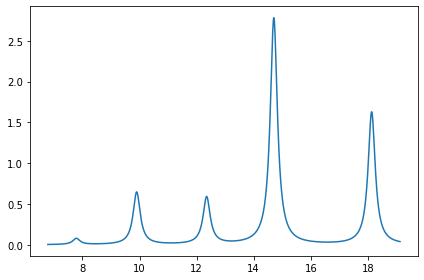

In [5]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi


au2ev = 27.211386

rpa_solver = LinearResponseEigenSolver(comm, ostream=silent_ostream)
rpa_solver.update_settings({"nstates": 6}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_drv.scf_tensors)

plt.figure(figsize=(6, 4))
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.3)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

Print results

In [6]:
print("Excitation energy (a.u.):", rpa_results["eigenvalues"])
print("Transition moments (a.u.):", rpa_results["electric_transition_dipoles"][0])
print("Oscillator strength:", rpa_results["oscillator_strengths"])

Excitation energy (a.u.): [0.286153 0.363831 0.364458 0.453917 0.540444 0.666422]
Transition moments (a.u.): [ 0.       -0.243207 -0.      ]
Oscillator strength: [0.011284 0.096515 0.       0.086843 0.416552 0.243768]


Calculate CPP

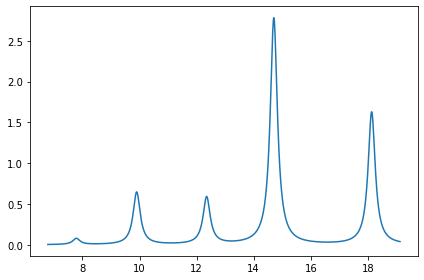

Excitation energy (a.u.): [0.286153 0.363831 0.364458 0.453917 0.540444 0.666422]
Transition moments (a.u.): [0.       0.243207 0.      ]
Oscillator strength: [0.011284 0.096515 0.       0.086843 0.416552 0.243768]


In [3]:
# Define spectrum region to be resolved
freqs = np.arange(7.0, 23.0, 0.1) / au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection(
    {"frequencies": ",".join(freqs_str), "damping": 0.3 / au2ev}, method_settings
)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property["response_functions"][("x", "x", w)].imag
    ayy = -cpp_prop.rsp_property["response_functions"][("y", "y", w)].imag
    azz = -cpp_prop.rsp_property["response_functions"][("z", "z", w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

## Recommendations

- Loads of studies out there
- Depends on property under consideration
    - Can be challenging to make work for several properties at the same time
- Avoid functional fishing
- Benchmark with higher theory

## Exercises


### Functional dependence

Consider ethanol:

```python
ch3oh = '''
C       0.6627602692    -0.0195253241    -0.0000000000
O      -0.7482324502     0.1217146925     0.0000000000
H       1.0282229693    -0.5397922417    -0.8872632580
H       1.0282229693    -0.5397922417     0.8872632580
H       1.0781531801     0.9835591659    -0.0000000000
H      -1.1253011321    -0.7605402778     0.0000000000
'''
```

Calculate the valence spectra using TDHF and TDDFT with the following functionals:
- BLYP
- B3LYP
- BHandHLYP

Plot and compare the resulting spectra:
- How do the absolute energies compare?
    - Compare this to the HOMO-LUMO gaps
- Calculate a reference spectra using ADC(2)
    - Which lower-level method is closest?


### Charge-transfer

Consider the ethylene-tetrafluoroethylene dimer from [this](https://aip.scitation.org/doi/10.1063/1.1590951) famous paper, using these approximate (monomer) dimers:

```python
c2h4 = """
C        0.6655087212      0.0000000000      0.0000000000                 
C       -0.6655087212      0.0000000000      0.0000000000                 
H        1.2112231877      0.9379948213      0.0000000000                 
H        1.2112231877     -0.9379948213      0.0000000000                 
H       -1.2112231877      0.9379948213      0.0000000000                 
H       -1.2112231877     -0.9379948213      0.0000000000   
"""

c2f4 = """
C        0.6665934397      0.0000000000      0.0000000000                 
C       -0.6665934397     -0.0000000000      0.0000000000                 
F        1.3499511337      1.1743643195      0.0000000000                 
F        1.3499511337     -1.1743643195      0.0000000000                 
F       -1.3499511337      1.1743643195      0.0000000000                 
F       -1.3499511337     -1.1743643195      0.0000000000   
"""
```

Calculate the distance dependence of TDHF and TDDFT (BLYP, B3LYP, BHandHLYP) to reproduce the erroneous results presented in the original article. See if you can correct this using the estimation presented in there, where:

$$
E_{\textrm{CT}}(r) \approx \textrm{IP}_A + \textrm{EA}_B - 1/R.
$$



### Triplet instability

Consider the triplet instabilities discussed in [this](https://pubs.acs.org/doi/abs/10.1021/ct200651r) article, and reproduce the results for ethene.

Consider the full RPA and TDA. Use ADC(2) for reference calculations.

```{note}
**To be added:**
- CT influence of twisted molecule
    - 6-31G*
    - BxLYP (TDHF to BLYP)
    - Ref. from ADC(2)
```